In [1]:
import polars as pl

# Load the data
df_child = pl.read_excel("data/policy_tracker.xlsx", sheet_name="4. US State - Current Child")

# Get the 4 passed bills
passed_bills = df_child.filter(
    pl.col("Status (optional)").str.contains("(?i)passed|act |chaptered")
)

print("=== PASSED BILLS - FULL TEXT ===\n")

for i, row in enumerate(passed_bills.iter_rows(named=True)):
    print(f"\n{'='*80}")
    print(f"BILL #{i+1}")
    print(f"State: {row['US State']}")
    print(f"Name: {row['Name']}")
    print(f"Intro Date: {row['Intro Date']}")
    print(f"Status: {row['Status (optional)']}")
    print(f"\nDescription:")
    print(row['Description'])
    print(f"{'='*80}")

print("\n\n=== SAMPLE OF PROPOSED BILLS ===\n")

# Get 5 random proposed bills
sample_bills = df_child.sample(5)

for i, row in enumerate(sample_bills.iter_rows(named=True)):
    print(f"\n{'='*80}")
    print(f"SAMPLE #{i+1}")
    print(f"State: {row['US State']}")
    print(f"Name: {row['Name']}")
    print(f"\nDescription:")
    print(row['Description'])
    print(f"{'='*80}")

Could not determine dtype for column 14, falling back to string


=== PASSED BILLS - FULL TEXT ===


BILL #1
State: Arkansas
Name: To create the protection of minors from distribution of harmful material act;  to establish liability for the publication or distribution of material harmful to minors on the internet;  and to require reasonable age verification.
Intro Date: 2023-01-17
Status: 4/11/2023 - Passed, now Act 612 - 100% progression

Description:
Requires age verification to access websites that are more than one-third pornography. Retaining ID information prohibited.

BILL #2
State: Arkansas
Name: To create the social media safety act;  to require age verification for use of social media;  and to clarify liability for failure to perform age verification for use of social media and illegal retention of data.
Intro Date: 2023-03-09
Status: 4/11/2023 - Passed, now Act 689 - 100% progression

Description:
Requires age verification / parental consent to open social media accounts, with significant exclusions. Retaining ID information prohibited.

B

In [ ]:
import polars as pl
import json
import os
from anthropic import Anthropic

# Set your API key
os.environ['ANTHROPIC_API_KEY'] = 'api-key'

# Initialize client
client = Anthropic()

# Load bills
df_child = pl.read_excel("data/policy_tracker.xlsx", sheet_name="4. US State - Current Child")

features_list = []

for i, bill in enumerate(df_child.to_dicts()):
    print(f"Processing {i+1}/146: {bill['US State']} - {bill['Name'][:40]}...")
    
    prompt = f"""You are analyzing US state child safety legislation. For each bill, determine if specific policy mechanisms are PRIMARY, REQUIRED features.

Bill Name: {bill['Name']}
Bill Description: {bill['Description']}

Mark TRUE only if the mechanism is explicitly required by the bill. Mark FALSE if only mentioned, suggested, or optional.

DEFINITIONS:
- age_verification: Bill REQUIRES platforms to verify users are above minimum age (e.g., via ID, facial scan)
- parental_consent: Bill REQUIRES parental permission/notification before minors can create accounts or use features
- data_collection_limits: Bill RESTRICTS what personal data companies can collect, use, or sell from minors
- algorithmic_restrictions: Bill REGULATES recommendation algorithms, autoplay, infinite scroll, or other addictive features
- duty_of_care: Bill establishes a LEGAL STANDARD requiring platforms to design for child safety
- risk_assessment_required: Bill MANDATES platforms conduct and report safety risk assessments
- default_privacy_settings: Bill REQUIRES privacy-protective settings by default for minors
- school_based: Bill focuses on SCHOOLS (curricula, training, filtering) rather than regulating platforms
- targets_all_platforms: Bill applies to ALL online services (TRUE) vs specific platforms like pornography sites only (FALSE)

EXAMPLES:
- "Requires age verification to access pornography websites" → age_verification: true, targets_all_platforms: false
- "Prohibits selling personal data of users under 13" → data_collection_limits: true
- "Platforms must disable autoplay for minor accounts" → algorithmic_restrictions: true
- "Schools must teach digital literacy" → school_based: true
- "Creates task force to study online safety" → all false (procedural, not regulatory)

Answer with ONLY valid JSON (no markdown, no explanation):

{{
  "age_verification": true/false,
  "parental_consent": true/false,
  "data_collection_limits": true/false,
  "algorithmic_restrictions": true/false,
  "duty_of_care": true/false,
  "risk_assessment_required": true/false,
  "default_privacy_settings": true/false,
  "school_based": true/false,
  "targets_all_platforms": true/false
}}

Be conservative. When uncertain, mark FALSE."""
    
    try:
        message = client.messages.create(
            model="claude-sonnet-4-20250514",
            max_tokens=1000,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )
        
        # Extract JSON from response
        text = message.content[0].text
        
        # Remove markdown code blocks if present
        text = text.replace('```json', '').replace('```', '').strip()
        
        features = json.loads(text)
        features['state'] = bill['US State']
        features['name'] = bill['Name']
        features_list.append(features)
        
        # Show what it classified
        true_features = [k for k, v in features.items() if v == True and k not in ['state', 'name']]
        if true_features:
            print(f"  ✓ {', '.join(true_features)}")
        else:
            print(f"  ✓ No primary mechanisms detected")
            
    except Exception as e:
        print(f"  ✗ Error: {e}")

# Save results
with open('bill_features_claude.json', 'w') as f:
    json.dump(features_list, f, indent=2)

features_df = pl.DataFrame(features_list)

print("\n\n=== CLAUDE CLASSIFICATION RESULTS ===")
print(f"Total bills processed: {len(features_list)}/146\n")

for col in ['age_verification', 'parental_consent', 'data_collection_limits', 
            'algorithmic_restrictions', 'duty_of_care', 'risk_assessment_required',
            'default_privacy_settings', 'school_based', 'targets_all_platforms']:
    count = features_df[col].sum()
    print(f"{col}: {count}/{len(features_list)} bills ({count/len(features_list)*100:.1f}%)")

# Spot check: Show some age verification bills
age_verify_bills = features_df.filter(pl.col('age_verification') == True)
print(f"\n\n=== BILLS WITH AGE VERIFICATION ({len(age_verify_bills)}) ===")
print(age_verify_bills.select(['state', 'name']).head(10))

Could not determine dtype for column 14, falling back to string


Processing 1/146: Alabama - Relating to consumer protection;  to req...
  ✓ default_privacy_settings
Processing 2/146: Arizona - To create the protection of minors from ...
  ✓ age_verification
Processing 3/146: Arkansas - To create the protection of minors from ...
  ✓ age_verification, data_collection_limits
Processing 4/146: Arkansas - To create the social media safety act;  ...
  ✓ age_verification, parental_consent, data_collection_limits, targets_all_platforms
Processing 5/146: California - Business regulations: sexually explicit ...
  ✓ age_verification, data_collection_limits
Processing 6/146: California - The California Age-Appropriate Design Co...
  ✓ data_collection_limits, risk_assessment_required, targets_all_platforms
Processing 7/146: California - Features that harm child users: civil pe...
  ✓ algorithmic_restrictions, duty_of_care, risk_assessment_required, targets_all_platforms
Processing 8/146: California - Social media platforms: minor users: civ...
  ✓ algorithmic_

In [30]:
features_df = pl.DataFrame(features_list)

# Check age verification bills
age_verify = features_df.filter(pl.col('age_verification') == True)
print(f"Age verification bills: {len(age_verify)}")
print(age_verify.select(['state', 'name']).head(10))

# Check procedural bills (should have minimal features)
feature_cols = ['age_verification', 'parental_consent', 'data_collection_limits', 
                'algorithmic_restrictions', 'duty_of_care', 'risk_assessment_required',
                'default_privacy_settings', 'school_based', 'targets_all_platforms']

features_df_with_sum = features_df.with_columns(
    pl.sum_horizontal([pl.col(c).cast(pl.Int32) for c in feature_cols]).alias('total_features')
)

no_features = features_df_with_sum.filter(pl.col('total_features') == 0)
print(f"\nBills with NO features: {len(no_features)}")
print(no_features.select(['state', 'name']).head(5))

Age verification bills: 44
shape: (10, 2)
┌─────────────┬─────────────────────────────────┐
│ state       ┆ name                            │
│ ---         ┆ ---                             │
│ str         ┆ str                             │
╞═════════════╪═════════════════════════════════╡
│ Arizona     ┆ To create the protection of mi… │
│ Arkansas    ┆ To create the protection of mi… │
│ Arkansas    ┆ To create the social media saf… │
│ California  ┆ Business regulations: sexually… │
│ Connecticut ┆ An act concerning cyberbullyin… │
│ Florida     ┆ Protection of Exploited Person… │
│ Florida     ┆ Childhood Mental Health, Safet… │
│ Iowa        ┆ An Act relating to civil liabi… │
│ Iowa        ┆ An Act relating to social medi… │
│ Iowa        ┆ An Act relating to parental co… │
└─────────────┴─────────────────────────────────┘

Bills with NO features: 24
shape: (5, 2)
┌───────────────┬─────────────────────────────────┐
│ state         ┆ name                            │
│ ---       

In [31]:
# Save the results
with open('bill_features_claude.json', 'w') as f:
    json.dump(features_list, f, indent=2)

features_df.write_csv('bill_features_claude.csv')

print("✅ Saved Claude classification results")
print("\nReady for paradigm analysis!")

✅ Saved Claude classification results

Ready for paradigm analysis!


=== VERIFICATION ===
age_verification: 44
parental_consent: 25
data_collection_limits: 67
algorithmic_restrictions: 18
duty_of_care: 7
risk_assessment_required: 20
default_privacy_settings: 22
school_based: 23
targets_all_platforms: 56

✅ Saved: child_safety_analysis_fixed.png


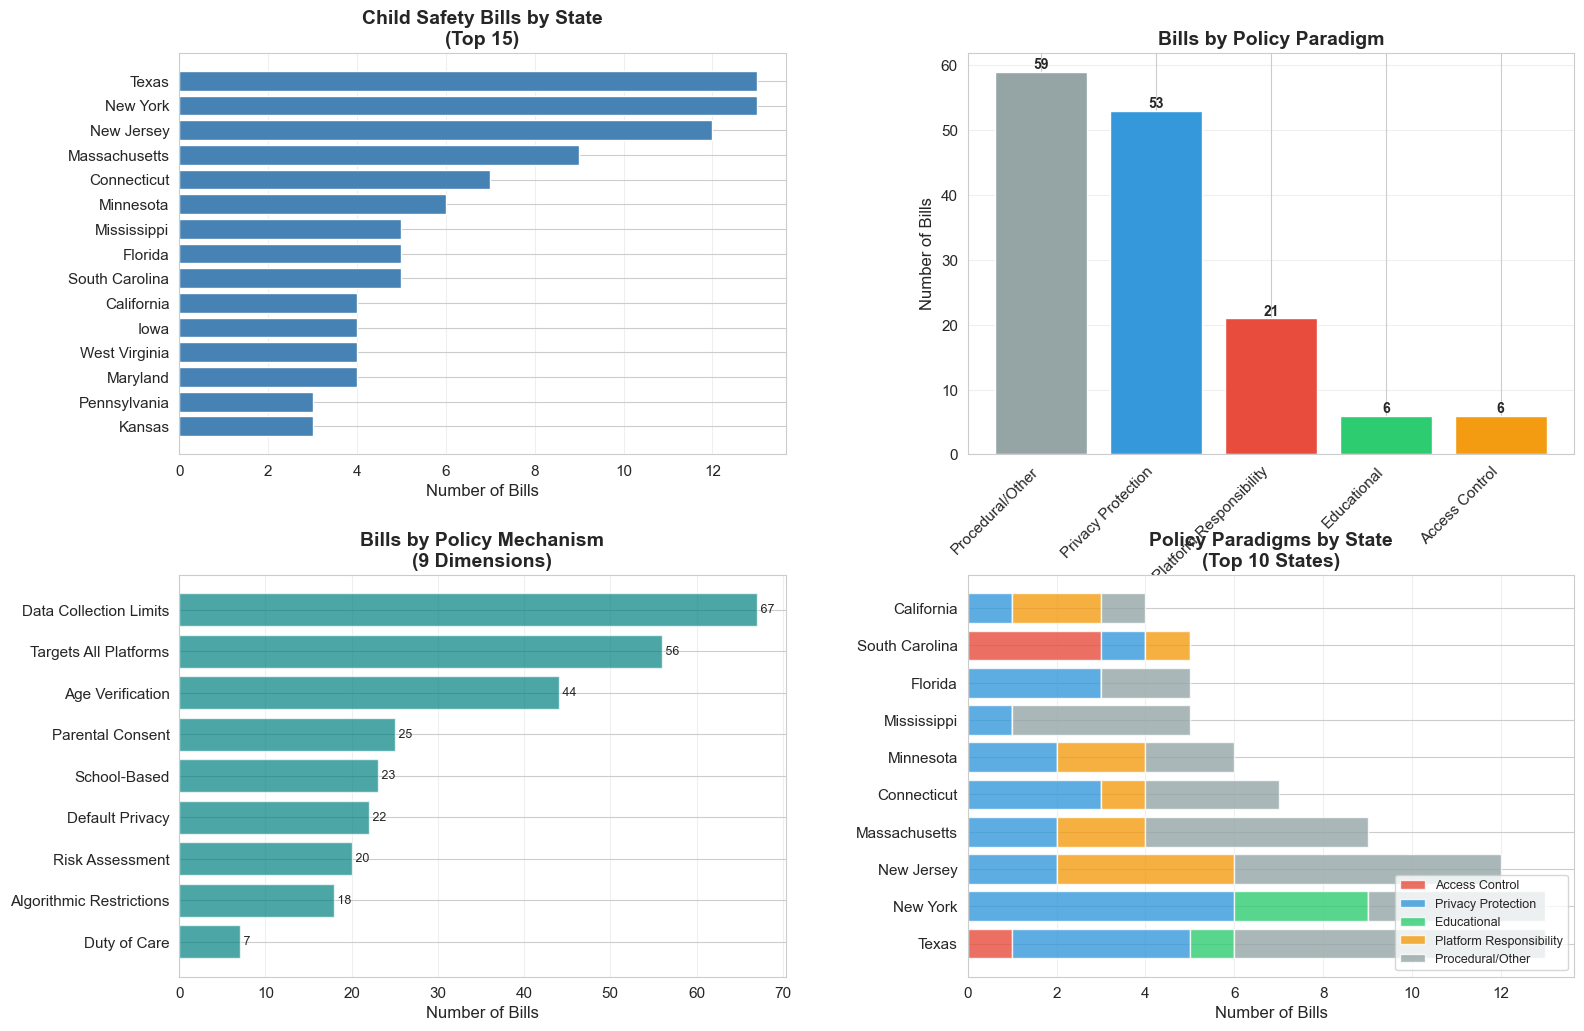

In [36]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CORRECT Claude classification
features_df = pl.read_csv('bill_features_claude.csv')

# Verify the counts first
print("=== VERIFICATION ===")
feature_cols = ['age_verification', 'parental_consent', 'data_collection_limits', 
                'algorithmic_restrictions', 'duty_of_care', 'risk_assessment_required',
                'default_privacy_settings', 'school_based', 'targets_all_platforms']

for col in feature_cols:
    count = features_df[col].sum()
    print(f"{col}: {count}")

# Now recreate the visualization with correct data
sns.set_style("whitegrid")
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

# ===== PLOT 1: Bills by State (Top 15) =====
state_counts = features_df.group_by("state").agg(
    pl.len().alias("count")
).sort("count", descending=True).head(15)

ax1.barh(state_counts['state'].to_list()[::-1], state_counts['count'].to_list()[::-1], color='steelblue')
ax1.set_xlabel('Number of Bills', fontsize=12)
ax1.set_title('Child Safety Bills by State\n(Top 15)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# ===== PLOT 2: Bills by Paradigm =====
# Load paradigm data
with open('bill_features_with_paradigms.json', 'r') as f:
    import json
    paradigm_data = json.load(f)

paradigm_df = pl.DataFrame(paradigm_data)

# Recreate paradigm_group
def group_paradigms(paradigm):
    if paradigm in ['Age Verification Only', 'Access Control']:
        return 'Access Control'
    elif paradigm in ['Data Privacy Only', 'Privacy-First']:
        return 'Privacy Protection'
    elif paradigm == 'Platform Responsibility':
        return 'Platform Responsibility'
    elif paradigm == 'Educational':
        return 'Educational'
    else:
        return 'Procedural/Other'

paradigm_groups = [group_paradigms(p) for p in paradigm_df['paradigm'].to_list()]
paradigm_df = paradigm_df.with_columns(pl.Series("paradigm_group", paradigm_groups))

paradigm_counts = paradigm_df.group_by("paradigm_group").agg(
    pl.len().alias("count")
).sort("count", descending=True)

colors = ['#95a5a6', '#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = ax2.bar(range(len(paradigm_counts)), paradigm_counts['count'].to_list(), color=colors)
ax2.set_ylabel('Number of Bills', fontsize=12)
ax2.set_title('Bills by Policy Paradigm', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(paradigm_counts)))
ax2.set_xticklabels(paradigm_counts['paradigm_group'].to_list(), rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ===== PLOT 3: Bills by Feature (FIXED) =====
feature_names = {
    'data_collection_limits': 'Data Collection Limits',
    'targets_all_platforms': 'Targets All Platforms',
    'age_verification': 'Age Verification',
    'parental_consent': 'Parental Consent',
    'school_based': 'School-Based',
    'default_privacy_settings': 'Default Privacy',
    'risk_assessment_required': 'Risk Assessment',
    'algorithmic_restrictions': 'Algorithmic Restrictions',
    'duty_of_care': 'Duty of Care'
}

feature_counts = []
for feature, label in feature_names.items():
    count = features_df[feature].sum()
    feature_counts.append((label, count))

feature_counts.sort(key=lambda x: x[1], reverse=True)
labels, counts = zip(*feature_counts)

bars = ax3.barh(range(len(labels))[::-1], counts, color='teal', alpha=0.7)
ax3.set_yticks(range(len(labels)))
ax3.set_yticklabels(labels[::-1])
ax3.set_xlabel('Number of Bills', fontsize=12)
ax3.set_title('Bills by Policy Mechanism\n(9 Dimensions)', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for i, bar in enumerate(bars):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2.,
            f' {int(width)}',
            ha='left', va='center', fontsize=9)

# ===== PLOT 4: Paradigms by State =====
top_10_states = state_counts.head(10)['state'].to_list()

state_paradigm_data = {}
for state in top_10_states:
    state_bills = paradigm_df.filter(pl.col('state') == state)
    paradigm_dist = state_bills.group_by('paradigm_group').agg(pl.len().alias('count'))
    state_paradigm_data[state] = {row['paradigm_group']: row['count'] for row in paradigm_dist.to_dicts()}

paradigm_order = ['Access Control', 'Privacy Protection', 'Educational', 'Platform Responsibility', 'Procedural/Other']
colors_dict = {
    'Access Control': '#e74c3c',
    'Privacy Protection': '#3498db', 
    'Educational': '#2ecc71',
    'Platform Responsibility': '#f39c12',
    'Procedural/Other': '#95a5a6'
}

bottoms = [0] * len(top_10_states)
for paradigm in paradigm_order:
    counts = [state_paradigm_data[state].get(paradigm, 0) for state in top_10_states]
    ax4.barh(range(len(top_10_states)), counts, left=bottoms, 
             label=paradigm, color=colors_dict[paradigm], alpha=0.8)
    bottoms = [b + c for b, c in zip(bottoms, counts)]

ax4.set_yticks(range(len(top_10_states)))
ax4.set_yticklabels(top_10_states)
ax4.set_xlabel('Number of Bills', fontsize=12)
ax4.set_title('Policy Paradigms by State\n(Top 10 States)', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right', fontsize=9)
ax4.grid(axis='x', alpha=0.3)

plt.savefig('child_safety_analysis_fixed.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: child_safety_analysis_fixed.png")
plt.show()

Could not determine dtype for column 14, falling back to string


=== PASSED/ENACTED BILLS ===
Total passed: 3 out of 146

PASSED BILLS:

Arkansas: To create the protection of minors from distribution of harmful material act;  t
  Status: 4/11/2023 - Passed, now Act 612 - 100% progression
  Paradigm: Procedural/Other
  Features: age_verification, data_collection_limits

Arkansas: To create the social media safety act;  to require age verification for use of s
  Status: 4/11/2023 - Passed, now Act 689 - 100% progression
  Paradigm: Privacy Protection
  Features: age_verification, parental_consent, data_collection_limits, targets_all_platforms

Connecticut: An act concerning online privacy, data and safety protections.
  Status: 6/26/2023 - Passed - 100% progression
  Paradigm: Platform Responsibility
  Features: parental_consent, data_collection_limits, duty_of_care, risk_assessment_required, targets_all_platforms


✅ Saved: passed_bills_analysis.png


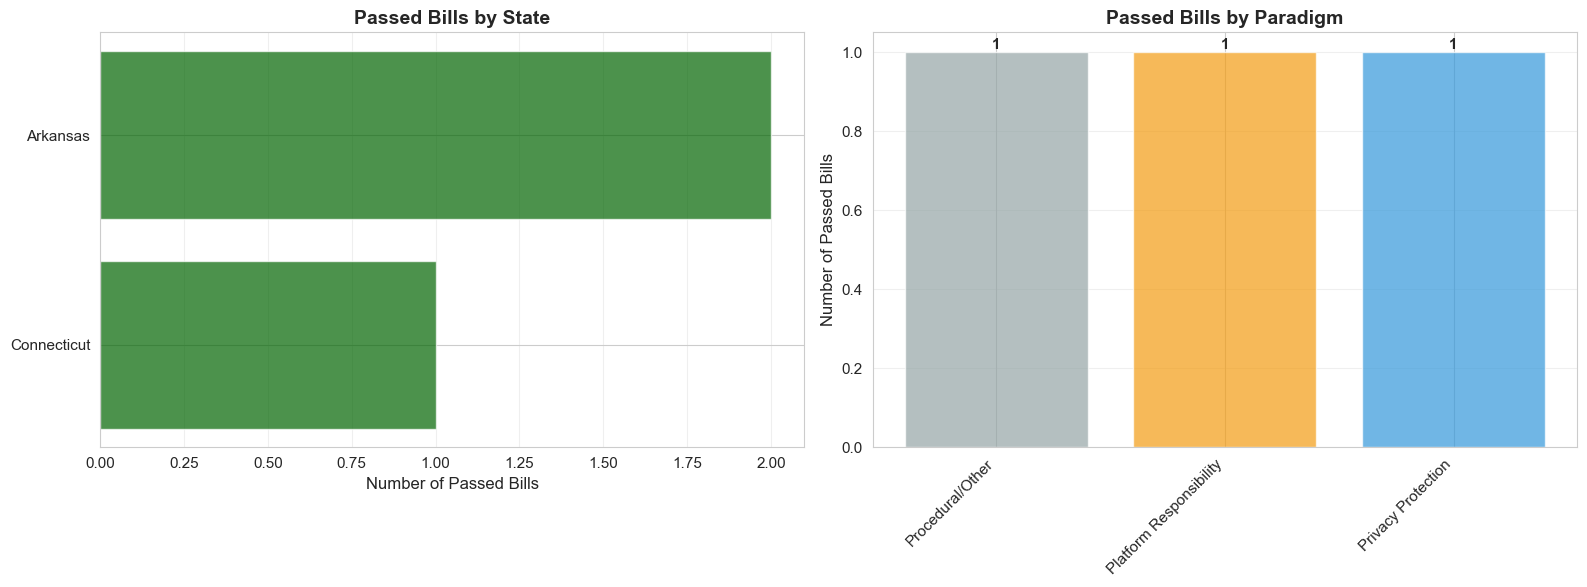



=== FEATURE BREAKDOWN OF PASSED BILLS ===

Age Verification               2/3 (66.7%)
Parental Consent               2/3 (66.7%)
Data Collection Limits         3/3 (100.0%)
Algorithmic Restrictions       0/3 (0.0%)
Duty of Care                   1/3 (33.3%)
Risk Assessment                1/3 (33.3%)
Default Privacy                0/3 (0.0%)
School-Based                   0/3 (0.0%)
Targets All Platforms          2/3 (66.7%)


In [35]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Load the classified data
features_df = pl.read_csv('bill_features_claude.csv')

# Recreate paradigm_group if needed
if 'paradigm_group' not in features_df.columns:
    def group_paradigms(paradigm):
        if paradigm in ['Age Verification Only', 'Access Control']:
            return 'Access Control'
        elif paradigm in ['Data Privacy Only', 'Privacy-First']:
            return 'Privacy Protection'
        elif paradigm == 'Platform Responsibility':
            return 'Platform Responsibility'
        elif paradigm == 'Educational':
            return 'Educational'
        else:
            return 'Procedural/Other'
    
    # Load original paradigm classifications
    with open('bill_features_with_paradigms.json', 'r') as f:
        paradigm_data = json.load(f)
    
    paradigm_df = pl.DataFrame(paradigm_data).select(['state', 'name', 'paradigm'])
    features_df = features_df.join(paradigm_df, on=['state', 'name'], how='left')
    
    paradigm_groups = [group_paradigms(p) for p in features_df['paradigm'].to_list()]
    features_df = features_df.with_columns(pl.Series("paradigm_group", paradigm_groups))

# Load original data to get status
df_child = pl.read_excel("data/policy_tracker.xlsx", sheet_name="4. US State - Current Child")

# Merge to get status information
features_df = features_df.join(
    df_child.select(['US State', 'Name', 'Status (optional)']),
    left_on=['state', 'name'],
    right_on=['US State', 'Name'],
    how='left'
)

# FIXED: Better status filter - must contain "Passed" or "Act" and NOT "Referred"
passed_bills = features_df.filter(
    (pl.col('Status (optional)').str.to_lowercase().str.contains('passed|act [0-9]', literal=False)) &
    (~pl.col('Status (optional)').str.to_lowercase().str.contains('referred', literal=False))
)

print("=== PASSED/ENACTED BILLS ===")
print(f"Total passed: {len(passed_bills)} out of 146\n")

# Show the passed bills
if len(passed_bills) > 0:
    print("PASSED BILLS:")
    for bill in passed_bills.iter_rows(named=True):
        print(f"\n{bill['state']}: {bill['name'][:80]}")
        print(f"  Status: {bill['Status (optional)']}")
        print(f"  Paradigm: {bill.get('paradigm_group', bill.get('paradigm', 'Unknown'))}")
        
        # Show features
        features = []
        feature_cols = ['age_verification', 'parental_consent', 'data_collection_limits', 
                        'algorithmic_restrictions', 'duty_of_care', 'risk_assessment_required',
                        'default_privacy_settings', 'school_based', 'targets_all_platforms']
        
        for feat in feature_cols:
            if bill.get(feat, False):
                features.append(feat)
        
        if features:
            print(f"  Features: {', '.join(features)}")
        else:
            print(f"  Features: None (procedural)")

    # Create visualization
    sns.set_style("whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ===== PLOT 1: Passed Bills by State =====
    state_counts = passed_bills.group_by("state").agg(
        pl.len().alias("count")
    ).sort("count", descending=True)
    
    ax1.barh(state_counts['state'].to_list()[::-1], state_counts['count'].to_list()[::-1], 
             color='darkgreen', alpha=0.7)
    ax1.set_xlabel('Number of Passed Bills', fontsize=12)
    ax1.set_title('Passed Bills by State', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # ===== PLOT 2: Passed Bills by Paradigm =====
    paradigm_col = 'paradigm_group' if 'paradigm_group' in passed_bills.columns else 'paradigm'
    
    paradigm_counts = passed_bills.group_by(paradigm_col).agg(
        pl.len().alias("count")
    ).sort("count", descending=True)
    
    colors_dict = {
        'Access Control': '#e74c3c',
        'Privacy Protection': '#3498db', 
        'Educational': '#2ecc71',
        'Platform Responsibility': '#f39c12',
        'Procedural/Other': '#95a5a6'
    }
    
    bar_colors = [colors_dict.get(p, '#95a5a6') for p in paradigm_counts[paradigm_col].to_list()]
    
    bars = ax2.bar(range(len(paradigm_counts)), paradigm_counts['count'].to_list(), 
                   color=bar_colors, alpha=0.7)
    ax2.set_ylabel('Number of Passed Bills', fontsize=12)
    ax2.set_title('Passed Bills by Paradigm', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(len(paradigm_counts)))
    ax2.set_xticklabels(paradigm_counts[paradigm_col].to_list(), rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('passed_bills_analysis.png', dpi=300, bbox_inches='tight')
    print("\n\n✅ Saved: passed_bills_analysis.png")
    plt.show()
    
    # ===== Feature breakdown =====
    print("\n\n=== FEATURE BREAKDOWN OF PASSED BILLS ===\n")
    
    feature_names = {
        'age_verification': 'Age Verification',
        'parental_consent': 'Parental Consent',
        'data_collection_limits': 'Data Collection Limits',
        'algorithmic_restrictions': 'Algorithmic Restrictions',
        'duty_of_care': 'Duty of Care',
        'risk_assessment_required': 'Risk Assessment',
        'default_privacy_settings': 'Default Privacy',
        'school_based': 'School-Based',
        'targets_all_platforms': 'Targets All Platforms'
    }
    
    for feature, label in feature_names.items():
        count = passed_bills[feature].sum()
        pct = (count / len(passed_bills) * 100) if len(passed_bills) > 0 else 0
        print(f"{label:30} {count}/{len(passed_bills)} ({pct:.1f}%)")

else:
    print("\n⚠️  No bills with 'Passed' or 'Act' status (excluding 'Referred')")